In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os, time, datetime
from datetime import datetime
import glob
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from matplotlib.colors import LogNorm,PowerNorm,ListedColormap,LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
#https://github.com/SciTools/cartopy/issues/1246
#https://matplotlib.org/3.1.0/gallery/color/custom_cmap.html # choose cmap
#http://bbs.06climate.com/forum.php?mod=viewthread&tid=88327

C:\Users\xigrug\Anaconda3\Anaconda\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\xigrug\Anaconda3\Anaconda\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [17]:
def plotMap(filename,newcmap,name,varname,clim):
    cities=pd.read_table(filename,sep=',',na_values=[-9999])
    cities=cities[cities['count']>=10]
    #cities=cities[0<=cities['WDIR850']]
    #cities=cities[cities['WDIR850']<=90]
    # Extract the data we're interested in
    lat = cities['lat_bin'].values
    lon = cities['lon_bin'].values
    ccn = cities[name].values
    tcb = cities['Tcb1.0'].values
    #u850,v850=mpcalc.get_wind_components(cities['WSPD850'],cities['WDIR850'])
    lat_max=np.nanmax(lat)
    lon_max=np.nanmax(lon)
    lat_min=np.nanmin(lat)
    lon_min=np.nanmin(lon)
    ccn_max=np.nanmax(ccn)
    print(ccn_max)
    ccn_min=np.nanmin(ccn)
    print(ccn_min)
    tcb_max=np.nanmax(tcb)
    print(tcb_max)
    tcb_min=np.nanmin(tcb)
    print(tcb_min)
    #Set the projection information Cannot label gridlines on a LambertConformal plot. Only PlateCarree and Mercator plots are currently supported.
##add shapefile
    # add borders, coastline, rivers, lakes, and provinces of China
    fig = plt.figure(figsize=[15, 15])#比例也决定了间隔的大小
    ax= fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    #proj = ccrs.PlateCarree(central_longitude=118.8)
    #Create a figure with an axes object on which we will plot. Pass the projection to that axes.
    #fig, ax = plt.subplots(figsize=(11.8, 8),subplot_kw=dict(projection=proj))
    #ax.background_img(name='BM', resolution='high')
    #Zoom in
    ax.set_extent([105, 133, 15, 53])
    #axes[i].set_extent([115, 119, 22, 25])
    #axes[i].set_extent([115, 123, 27, 35])#yrd
    #axes[i].set_extent([110,  116, 20, 25])#prd
    #axes[i].set_extent([112, 121, 35, 43])#BTH
    #axes[i].set_extent([115, 119, 22, 26])#HX
    lon_formatter = LongitudeFormatter(number_format='.1f',
                                       degree_symbol='',
                                       dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.1f',
                                      degree_symbol='')
    ax.set_xticks([110, 120, 130],crs=ccrs.PlateCarree())
    ax.set_xticklabels([110, 120, 130],fontsize=20)  
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_yticks([20, 30, 40,50], crs=ccrs.PlateCarree())
    ax.set_yticklabels([20, 30, 40,50],fontsize=20)
    ax.yaxis.set_major_formatter(lat_formatter)
    #Add map features
    ax.add_feature(cfeature.LAND, facecolor='0.99') #Grayscale colors can be set using 0 (black) to 1 (white)
    ax.add_feature(cfeature.LAKES, alpha=0.9)  #Alpha sets transparency (0 is transparent, 1 is solid)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), zorder=10, linestyle=':') # high resolution
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), zorder=10, linestyle=':') # mediate resolution
    ax.add_feature(cfeature.RIVERS) # low resolution
    #ax.stock_img()
    ax.gridlines(ylocs=np.arange(0,90,5),xlocs=np.arange(0,180,5),draw_labels=False,linestyle='--',alpha=0.7)
    #axes[i].xaxis.set_major_formatter(lon_formatter)
    #We can use additional features from Natural Earth (http://www.naturalearthdata.com/features/)
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m',facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray', zorder=10)
    fname = 'D:\data\map\CHN_adm1.shp'
    adm1_shapes = list(Reader(fname).geometries())
    ax.add_geometries(adm1_shapes, crs=ccrs.PlateCarree(),edgecolor='black', facecolor='none', alpha=0.9,linewidths=0.8)
    #newcmap = cmocean.tools.crop_by_percent(cmocean.cm.phase_r, 20, which='both', N=40)
    #bounds = [0, 50, 100, 200, 500,
    #      800, 1000, 1200, 1400,1600]
    #norm = mpl.colors.BoundaryNorm(bounds, newcmap.N)
    #norm = mpl.colors.LogNorm()
    #norm = mpl.colors.SymLogNorm(linthresh=0.03, linscale=0.1, vmin=50, vmax=ccn_max)
    ccn_sca=ax.scatter(lon,lat,#latlon=True,
          c=ccn, s=(2*tcb+10),
          cmap=newcmap,norm=PowerNorm(gamma=0.7),alpha=0.8,transform=ccrs.PlateCarree()) #Normalize a given value to the 0-1 range on a log scale
          #cmap=CM.get_cmap('rainbow',40),norm=LogNorm(vmin=max(ccn.min(),0.1),clip=True),alpha=0.5,transform=ccrs.PlateCarree())
          #Normalize a given value to the 0-1 range on a log scale
          #cmap=CM.get_cmap('jet'),alpha=0.8,transform=ccrs.PlateCarree()) #Normalize a given value to the 0-1 range on a log scale
    #Add lat/lon gridlines every 20° to the map
    #plt.colorbar(label=r'CCN ($cm^{-3}$)')
    #plt.clim(0,1600)
    cax = fig.add_axes([0.81, 0.45, 0.02, 0.4])
    cbar=plt.colorbar(ccn_sca, cax, orientation='vertical',label=varname,extendfrac=1/15,extendrect=True)
    #plt.colorbar(label=r'CCN ($cm^{-3}$)')
    cbar.ax.tick_params(labelsize=25)
    cbar.set_label(varname,fontsize=25)
    ccn_sca.set_clim(clim[0],clim[1])
    #ccn_sca.xformatter = LONGITUDE_FORMATTER
    #ccn_sca.yformatter = LATITUDE_FORMATTER
    #ccn_sca.xlabel_style = {'size': 15, 'color': 'gray'}
    #ccn_sca.xlabel_style = {'color': 'red', 'weight': 'bold'}
# make legend with dummy points
    for a in [0,10,20]:
        plt.scatter([], [], c='k', alpha=0.5, s=(2*a+10),
                    label=str(a)+'')
    #plt.legend(scatterpoints=1, frameon=False,
    #           labelspacing=1, loc='lower left',title= 'AQI',
    #           bbox_to_anchor=(,0),ncol=5)
    leg=plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc=10,fontsize=20,
           bbox_to_anchor=(0.98,-0.4,0.8,0.2),
           borderaxespad=0, ncol=1)#mode="expand",
    leg.set_title('Tcb ($^\circ$C)',prop = {'size': 20, 'family':'sans-serif'})
    #plt.title("2013-2018 Summer", fontsize=20)
    #X, Y = np.meshgrid(lon, lat)
    #U, V = np.meshgrid(u850, v850)
    #ax.barbs(X, Y, U, V, length=5,
    #         sizes=dict(emptybarb=0.25, spacing=0.2, height=0.5),
    #         linewidth=0.95, transform=ccrs.PlateCarree())
    
    return ccn_sca

In [15]:
newcmap = cmocean.tools.crop_by_percent(cmocean.cm.ice, 1, which='both', N=20)
cmdict=cmocean.tools.get_dict(newcmap,N=10)
blue_red2 = LinearSegmentedColormap('BlueRed2', cmdict)
plt.register_cmap(cmap=blue_red2)
##cmocean.tools.crop(cmocean.cm.ice,0,200,50,N=9,dmax=None)
cmap=CM.get_cmap('BlueRed2',10) #with the name not the blue_red2

C:\Users\xigrug\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


0.503378571
0.020525
25.5
-2.5


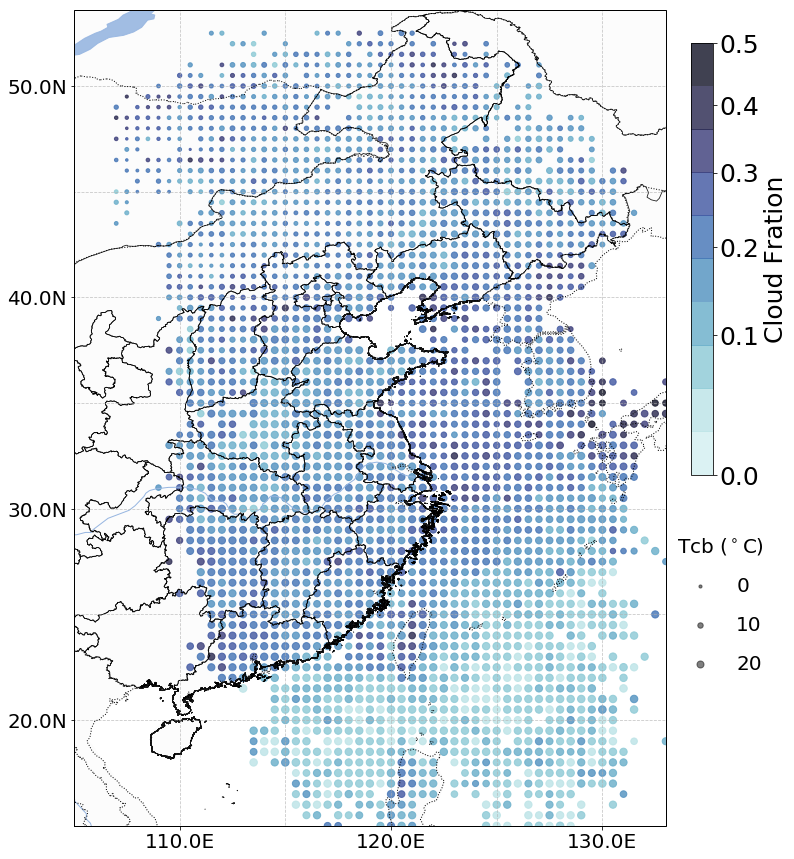

In [18]:
filename="1allsum-0.5-NaN-all_0-360_850hpa.csv"
newcmap = cmocean.tools.crop_by_percent(cmocean.cm.ice, 1, which='both', N=20)
varname="Cloud Fration"
name='Cloud_fra'
clim=[0,0.5]
ctt=plotMap(filename,cmap,name,varname,clim)
plt.savefig('avg_'+varname+'_filterplh-count10-new.png',bbox_inches='tight',dpi=600)

C:\Users\xigrug\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


2843.615385
490.46153849999996
25.5
-2.5


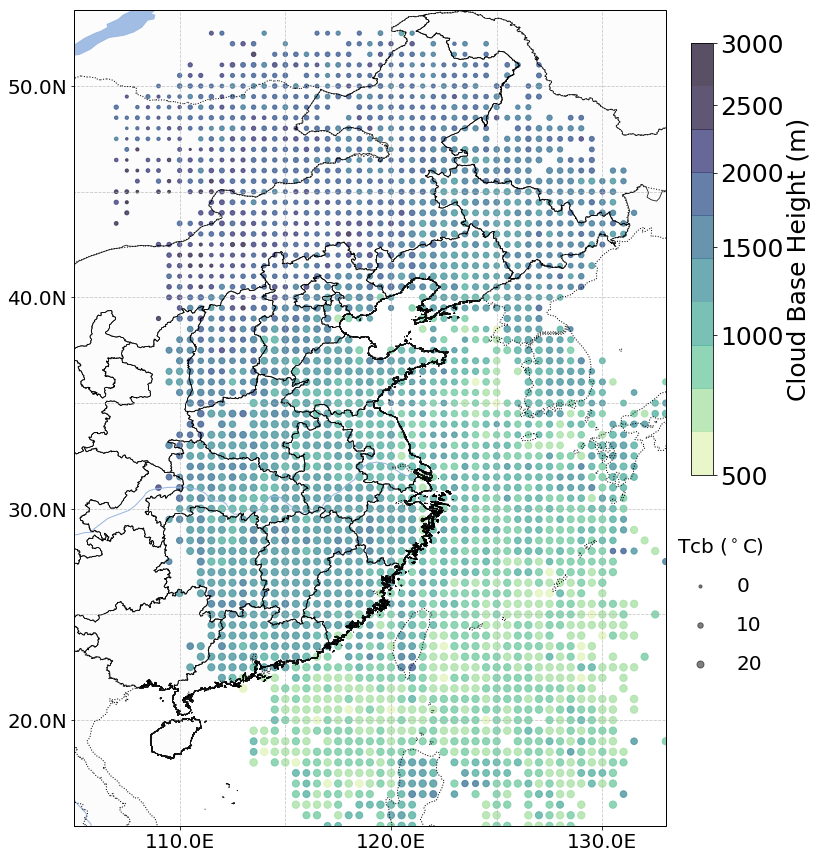

In [24]:
newcmap = cmocean.tools.crop_by_percent(cmocean.cm.deep, 1, which='both', N=20)
cmdict=cmocean.tools.get_dict(newcmap,N=10)
blue_red2 = LinearSegmentedColormap('BlueRed2', cmdict)
plt.register_cmap(cmap=blue_red2)
##cmocean.tools.crop(cmocean.cm.ice,0,200,50,N=9,dmax=None)
cmap=CM.get_cmap('BlueRed2',10) #with the name not the blue_red2
filename="1allsum-0.5-NaN-all_0-360_850hpa.csv"
newcmap = cmocean.tools.crop_by_percent(cmocean.cm.ice, 1, which='both', N=20)
varname="Cloud Base Height (m)"
name='Hcbs1.0'
clim=[500,3000]
ctt=plotMap(filename,cmap,name,varname,clim)
plt.savefig('avg_CloudBaseHeight_filterplh-count10-new.png',bbox_inches='tight',dpi=600)

C:\Users\xigrug\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


13.45
4.694444444
25.5
-2.5


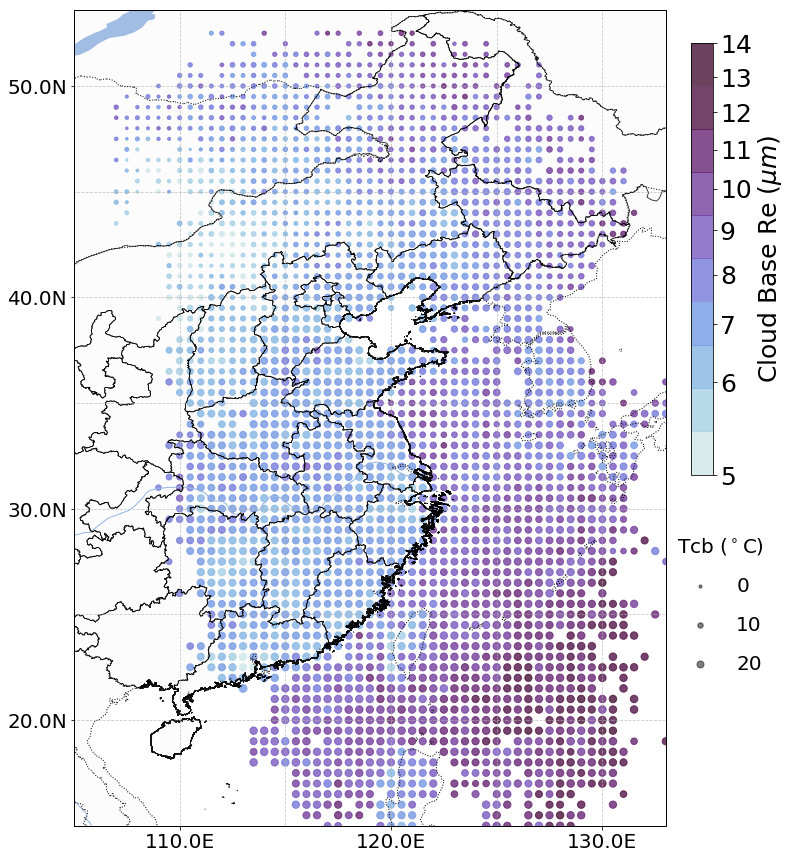

In [26]:
newcmap = cmocean.tools.crop_by_percent(cmocean.cm.dense, 1, which='both', N=20)
cmdict=cmocean.tools.get_dict(newcmap,N=10)
blue_red2 = LinearSegmentedColormap('BlueRed2', cmdict)
plt.register_cmap(cmap=blue_red2)
##cmocean.tools.crop(cmocean.cm.ice,0,200,50,N=9,dmax=None)
cmap=CM.get_cmap('BlueRed2',10) #with the name not the blue_red2
filename="1allsum-0.5-NaN-all_0-360_850hpa.csv"
newcmap = cmocean.tools.crop_by_percent(cmocean.cm.ice, 1, which='both', N=20)
varname="Cloud Base Re (${\mu}m$)"
name='Recb1.0'
clim=[5,14]
ctt=plotMap(filename,cmap,name,varname,clim)
plt.savefig('avg_CloudBaseRe_filterplh-count10-new.png',bbox_inches='tight',dpi=600)

C:\Users\xigrug\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


2.56
0.44076923100000004
25.5
-2.5


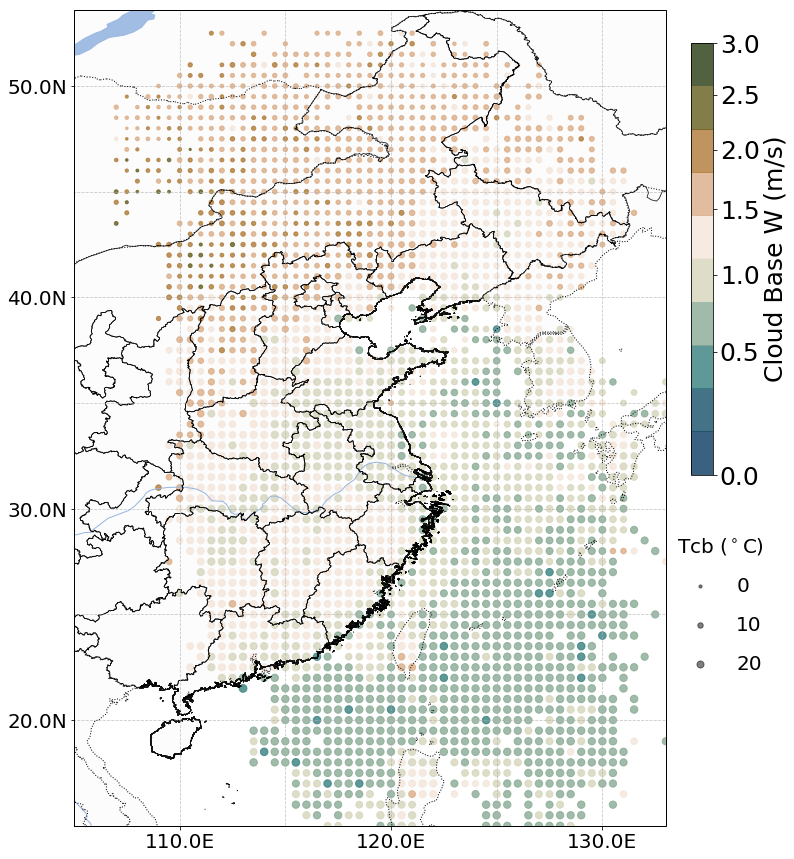

In [28]:
newcmap = cmocean.tools.crop_by_percent(cmocean.cm.tarn, 1, which='both', N=20)
cmdict=cmocean.tools.get_dict(newcmap,N=10)
blue_red2 = LinearSegmentedColormap('BlueRed2', cmdict)
plt.register_cmap(cmap=blue_red2)
##cmocean.tools.crop(cmocean.cm.ice,0,200,50,N=9,dmax=None)
cmap=CM.get_cmap('BlueRed2',10) #with the name not the blue_red2
filename="1allsum-0.5-NaN-all_0-360_850hpa.csv"
newcmap = cmocean.tools.crop_by_percent(cmocean.cm.ice, 1, which='both', N=20)
varname="Cloud Base W (m/s)"
name='Wb_1.0'
clim=[0,3]
ctt=plotMap(filename,cmap,name,varname,clim)
plt.savefig('avg_CloudBaseW_filterplh-count10-new.png',bbox_inches='tight',dpi=600)

C:\Users\xigrug\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


0.908333333
0.10875
25.5
-2.5


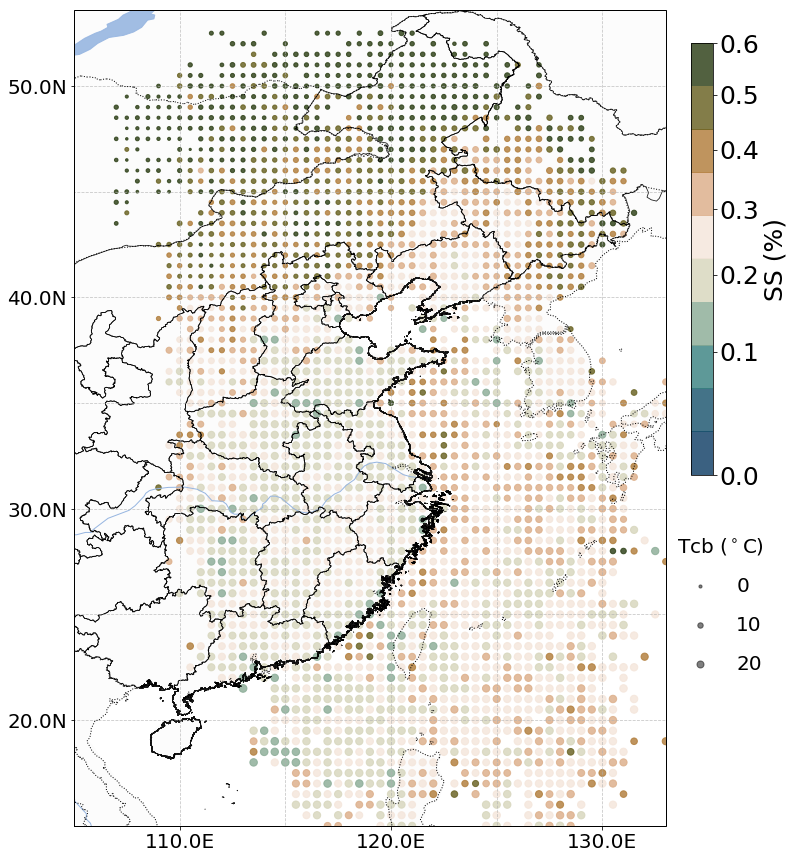

In [29]:
newcmap = cmocean.tools.crop_by_percent(cmocean.cm.tarn, 1, which='both', N=20)
cmdict=cmocean.tools.get_dict(newcmap,N=10)
blue_red2 = LinearSegmentedColormap('BlueRed2', cmdict)
plt.register_cmap(cmap=blue_red2)
##cmocean.tools.crop(cmocean.cm.ice,0,200,50,N=9,dmax=None)
cmap=CM.get_cmap('BlueRed2',10) #with the name not the blue_red2
filename="1allsum-0.5-NaN-all_0-360_850hpa.csv"
newcmap = cmocean.tools.crop_by_percent(cmocean.cm.ice, 1, which='both', N=20)
varname="SS (%)"
name='SS_1.0_mg'
clim=[0,0.6]
ctt=plotMap(filename,cmap,name,varname,clim)
plt.savefig('avg_SS_filterplh-count10-new.png',bbox_inches='tight',dpi=600)

In [29]:
def plotMap4(filename,cmap,name,varname,clim,i):
    cities=pd.read_table(filename,sep=',',na_values=[-9999])
    if i==0:
        cities=cities[cities['count']>=10]
    #cities=cities[0<=cities['WDIR850']]
    #cities=cities[cities['WDIR850']<=90]
    # Extract the data we're interested in
    lat = cities['lat_bin'].values
    lon = cities['lon_bin'].values
    ccn = cities[name].values
    tcb = cities['Tcb1.0'].values
    #u850,v850=mpcalc.get_wind_components(cities['WSPD850'],cities['WDIR850'])
    lat_max=np.nanmax(lat)
    lon_max=np.nanmax(lon)
    lat_min=np.nanmin(lat)
    lon_min=np.nanmin(lon)
    ccn_max=np.nanmax(ccn)
    print(ccn_max)
    ccn_min=np.nanmin(ccn)
    print(ccn_min)
    tcb_max=np.nanmax(tcb)
    print(tcb_max)
    tcb_min=np.nanmin(tcb)
    print(tcb_min)
    #Set the projection information Cannot label gridlines on a LambertConformal plot. Only PlateCarree and Mercator plots are currently supported.
##add shapefile
    # add borders, coastline, rivers, lakes, and provinces of China
    #proj = ccrs.PlateCarree(central_longitude=118.8)
    #Create a figure with an axes object on which we will plot. Pass the projection to that axes.
    #fig, ax = plt.subplots(figsize=(11.8, 8),subplot_kw=dict(projection=proj))
    #ax.background_img(name='BM', resolution='high')
    #Zoom in
    axes[i].set_extent([98, 136, 15, 50])
    #axes[i].set_extent([115, 119, 22, 25])
    #axes[i].set_extent([115, 123, 27, 35])#yrd
    #axes[i].set_extent([110,  116, 20, 25])#prd
    #axes[i].set_extent([112, 121, 35, 43])#BTH
    #axes[i].set_extent([115, 119, 22, 26])#HX

    #Add map features
    axes[i].add_feature(cfeature.LAND, facecolor='0.99') #Grayscale colors can be set using 0 (black) to 1 (white)
    axes[i].add_feature(cfeature.LAKES, alpha=0.9)  #Alpha sets transparency (0 is transparent, 1 is solid)
    axes[i].add_feature(cfeature.BORDERS.with_scale('10m'), zorder=10, linestyle=':') # high resolution
    axes[i].add_feature(cfeature.COASTLINE.with_scale('50m'), zorder=10, linestyle=':') # mediate resolution
    axes[i].add_feature(cfeature.RIVERS) # low resolution
    #ax.stock_img()
    axes[i].gridlines(ylocs=np.arange(0,90,5),xlocs=np.arange(0,180,5),draw_labels=False,linestyle='--',alpha=0.7)
    #axes[i].xaxis.set_major_formatter(lon_formatter)
    lon_formatter = LongitudeFormatter(number_format='.1f',
                                       degree_symbol='',
                                       dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.1f',
                                      degree_symbol='')
    '''
    if i in range(4,6,1):
        print(axes[i])
        axes[i].set_xticks([110, 112, 114, 116, 118, 120], crs=ccrs.PlateCarree())
    
        axes[i].xaxis.set_major_formatter(lon_formatter)
    if i in range(0,6,2):
        print(axes[i])
        axes[i].set_yticks([22, 23, 24, 25], crs=ccrs.PlateCarree())
        axes[i].yaxis.set_major_formatter(lat_formatter)
    '''
    #We can use additional features from Natural Earth (http://www.naturalearthdata.com/features/)
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m',facecolor='none')
    axes[i].add_feature(states_provinces, edgecolor='gray', zorder=10)
    fname = 'D:\data\map\CHN_adm1.shp'
    adm1_shapes = list(Reader(fname).geometries())
    axes[i].add_geometries(adm1_shapes, crs=ccrs.PlateCarree(),edgecolor='black', facecolor='none', alpha=0.9,linewidths=0.8)
    #newcmap = cmocean.tools.crop_by_percent(cmocean.cm.phase_r, 20, which='both', N=40)
    #bounds = [0, 50, 100, 200, 500,
    #      800, 1000, 1200, 1400,1600]
    #norm = mpl.colors.BoundaryNorm(bounds, newcmap.N)
    #norm = mpl.colors.LogNorm()
    #norm = mpl.colors.SymLogNorm(linthresh=0.03, linscale=0.1, vmin=50, vmax=ccn_max)
    ccn_sca=axes[i].scatter(lon,lat,#latlon=True,
          c=ccn, s=(2*tcb+10),
          cmap=cmap,norm=PowerNorm(gamma=0.7),alpha=0.5,transform=ccrs.PlateCarree()) #Normalize a given value to the 0-1 range on a log scale
          #cmap=CM.get_cmap('rainbow',40),norm=LogNorm(vmin=max(ccn.min(),0.1),clip=True),alpha=0.5,transform=ccrs.PlateCarree())
          #Normalize a given value to the 0-1 range on a log scale
          #cmap=CM.get_cmap('jet'),alpha=0.8,transform=ccrs.PlateCarree()) #Normalize a given value to the 0-1 range on a log scale
    #Add lat/lon gridlines every 20° to the map
    #plt.colorbar(label=r'CCN ($cm^{-3}$)')
    axes[i].set_title(varname,fontsize=20)
    cbar=plt.colorbar(ccn_sca, ax=axes[i], orientation='vertical',shrink=.60,pad=0.03)
    cbar.ax.tick_params(labelsize=20)
    #cbar.set_label(varname,fontsize=25)
    ccn_sca.set_clim(clim[2*i],clim[2*i+1])
    #ccn_sca.xformatter = LONGITUDE_FORMATTER
    #ccn_sca.yformatter = LATITUDE_FORMATTER
    #ccn_sca.xlabel_style = {'size': 15, 'color': 'gray'}
    #ccn_sca.xlabel_style = {'color': 'red', 'weight': 'bold'}
# make legend with dummy points
    '''
    for a in [0,10,20]:
        plt.scatter([], [], c='k', alpha=0.5, s=(15*a+20),
                label=str(a)+'')
#plt.legend(scatterpoints=1, frameon=False,
#           labelspacing=1, loc='lower left',title= 'AQI',
#           bbox_to_anchor=(,0),ncol=5)
    plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left',title= 'Tb-temperature',
           bbox_to_anchor=(0,-0.10,1,0.2),
           mode="expand", borderaxespad=0, ncol=6)
    '''
    #plt.title("2013-2018 Summer", fontsize=20)
    #X, Y = np.meshgrid(lon, lat)
    #U, V = np.meshgrid(u850, v850)
    #ax.barbs(X, Y, U, V, length=5,
    #         sizes=dict(emptybarb=0.25, spacing=0.2, height=0.5),
    #         linewidth=0.95, transform=ccrs.PlateCarree())
    
    return ccn_sca

C:\Users\xigrug\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


2843.615385
490.46153849999996
25.5
-2.5
19.8
2.2
26.0
-9.0
3.465
0.0
26.0
-9.0
1.45
0.0
26.0
-9.0


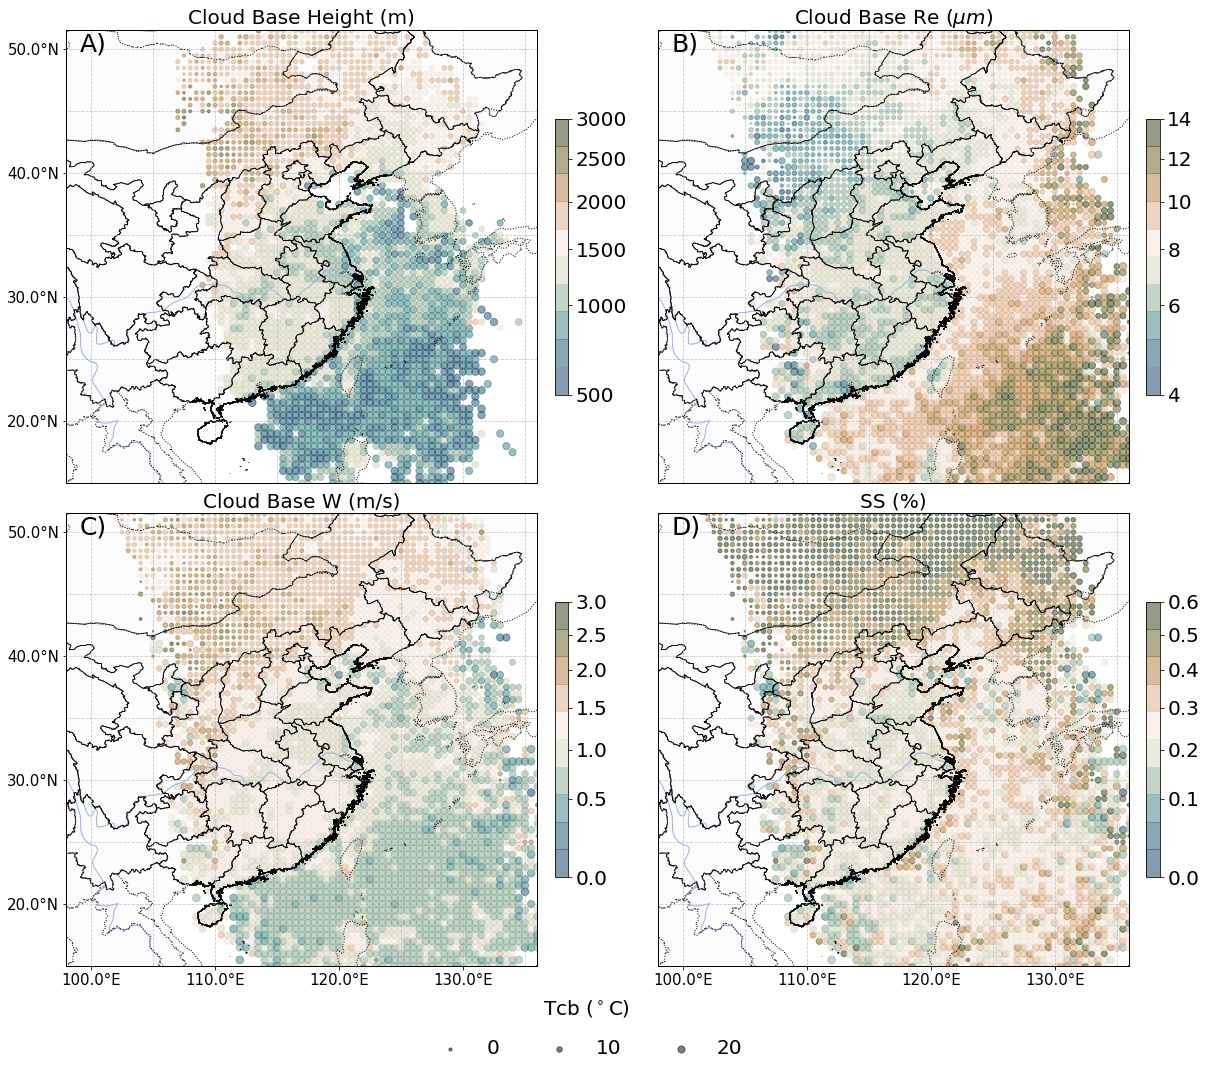

In [33]:
axes=['ax1', 'ax2','ax3','ax4']
NUM=['A)', 'B)','C)','D)']
fig = plt.figure(figsize=[18, 22])#比例也决定了间隔的大小
lon_formatter = LongitudeFormatter(number_format='.1f')
                                       #degree_symbol='',
                                       #dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.1f')
                                      #degree_symbol='')
    
axes[0] = fig.add_subplot(3,2,1,projection=ccrs.PlateCarree())
#axes[0].set_xticks([110, 112, 114, 116, 118, 120], crs=ccrs.PlateCarree())
#axes[0].xaxis.set_major_formatter(lon_formatter)
#axes[0].set_yticks([22, 23, 24, 25], crs=ccrs.PlateCarree())
#axes[0].yaxis.set_major_formatter(lat_formatter)
axes[1] = fig.add_subplot(3,2,2,projection=ccrs.PlateCarree(),sharex=axes[0],sharey=axes[0])
axes[2] = fig.add_subplot(3,2,3,projection=ccrs.PlateCarree(),sharex=axes[0],sharey=axes[0])
axes[3] = fig.add_subplot(3,2,4,projection=ccrs.PlateCarree(),sharex=axes[0],sharey=axes[0])
newcmap = cmocean.tools.crop_by_percent(cmocean.cm.tarn, 1, which='both', N=20)
cmdict=cmocean.tools.get_dict(newcmap,N=10)
blue_red2 = LinearSegmentedColormap('BlueRed2', cmdict)
plt.register_cmap(cmap=blue_red2)
##cmocean.tools.crop(cmocean.cm.ice,0,200,50,N=9,dmax=None)
cmap=CM.get_cmap('BlueRed2',10) #with the name not the blue_red2
filename="1allsum-0.5-NaN-all_0-360_850hpa.csv"
varname=["Cloud Base Height (m)","Cloud Base Re (${\mu}m$)","Cloud Base W (m/s)","SS (%)"]
name=['Hcbs1.0','Recb1.0','Wb_1.0','SS_1.0_mg']
clim=[500,3000,4,14,0,3,0,0.6]
for i in range(2,4,1):
    #if i in range(4,6,1):
    axes[i].set_xticks([100,110, 120, 130],crs=ccrs.PlateCarree())
    axes[i].set_xticklabels([100,110, 120, 130],fontsize=15)  
    axes[i].xaxis.set_major_formatter(lon_formatter)
for i in range(0,4,2):
    #if i in range(0,6,2):
    axes[i].set_yticks([20, 30, 40,50], crs=ccrs.PlateCarree())
    axes[i].set_yticklabels([20, 30, 40,50],fontsize=15)
    axes[i].yaxis.set_major_formatter(lat_formatter)
        
plt.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.05,wspace=0.03,hspace=0.05)

for i in range(0,4):
    #axes[i] = fig.add_subplot(3,2,i+1,projection=ccrs.PlateCarree(),sharex=ax1,sharey=ax1)
    #plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.05,hspace=0.05)
    ctt=plotMap4(filename,cmap,name[i],varname[i],clim,i)
    transform = ccrs.PlateCarree()._as_mpl_transform(axes[i])
    #axes[i].set_title('Plot title ' + str(i+1))
    axes[i].annotate(NUM[i],xy=(99.1,49.8),xycoords=transform,fontsize=25)
    #axes[i].annotate(NUM[i], xy=get_axis_limits(axes[i]),fontsize=15) 图片会变大
for a in [0,10,20]:
    plt.scatter([], [], c='k', alpha=0.5, s=2*a+10,
                label=str(a)+'')
#plt.legend(scatterpoints=1, frameon=False,
#           labelspacing=1, loc='lower left',title= 'AQI',
#           bbox_to_anchor=(,0),ncol=5)
leg=plt.legend(scatterpoints=1, frameon=False,
       labelspacing=1, loc='lower left',fontsize=20,
       bbox_to_anchor=(-0.5,-0.22,1,0.2),
       borderaxespad=0, ncol=3)
leg.set_title('Tcb ($^\circ$C)',prop = {'size': 20, 'family':'sans-serif'})
#plt.savefig("figureYRD-rih.pdf",bbox_inches='tight')
plt.savefig("figureChina-4v-count-ok.png",bbox_inches='tight',dpi=600)

fig.set_facecolor('w')
#plt.tight_layout()和subplots_adjust冲突